### Import relevant packages

In [2]:
import re

import pandas as pd
import re, string
import numpy as np
import matplotlib.pyplot as plt
import feather

from pathlib import Path
from collections import Counter
from multiprocessing import Pool
from urllib.parse import urlparse

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression

%matplotlib inline

### Read in data

In [55]:
path = Path('../Data/May2015_subset.fthr')
df = feather.read_dataframe(path)

### Preliminary EDA

**Size of the data**

In [56]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'5.128976683577038 GB'

**Features**
- `created_utc` - the time (in seconds) when the comment was posted 
- `ups` - number of upvotes on the comment
- `subreddit_id` - id of the specific subreddit
- `link_id` - id of the particular comment thread
- `name` - name of the comment
- `score_hidden` - 1 if the score of the comment was hidden; 0 else
- `author_flair_css_class` - 
- `author_flair_text` - 
- `id` - id of the comment (basically the same as comment name)
- `removal_reason` - reason a comment was removed (either `legal` or `None`)
- `gilded` - the number of gilded tags (~ premium likes) on the comment 
- `downs` - number of downvotes on the comment
- `archived` - if the thread was archived (no new comments, no new likes) 
- `author` - author's reddit username
- `score` - `ups - downs`
- `retrieved_on` - The time (in seconds) when the comment was pulled to create the dataset. 
- `body` - the comment itself
- `distinguished` - the type of user on the page. Either `moderator`, `admin`, or `None`. 
- `edited` - whether (1) or not (0) the comment has been edited
- `controversiality` - a Boolean indicating whether (1) or not (0) a comment is controversial -- i.e., popular comments that are getting closely the same amount of upvotes as downvotes. 
- `parent_id` - the id of the comment that this comment was replying to. `None` if the comment is not a reply

In [4]:
df.T[1] # one observation

created_utc                                                      1430438411
ups                                                                      12
subreddit_id                                                       t5_2qh22
link_id                                                           t3_34gfze
name                                                             t1_cqug99n
score_hidden                                                              0
author_flair_css_class                                                  MAL
author_flair_text           http://myanimelist.net/animelist/Link_of_Hyrule
subreddit                                                             anime
id                                                                  cqug99n
removal_reason                                                         None
gilded                                                                    0
downs                                                                     0
archived    

### Feature Engineering

Let's look at the size of the dataframe & explore if we want to build a model using all of the observations. 

In [5]:
df.shape

(6195172, 22)

The dataset houses 6,195,172 comments! Let's explore options of narrowing this dataset down. Our first idea is to handpick a set of subreddits. Let's visualize subreddits based on comments. 

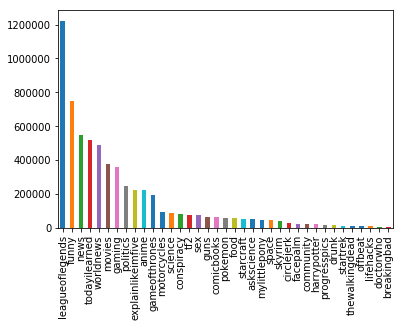

In [6]:
df.subreddit.value_counts().plot(kind='bar')

We'll narrow down our dataset to five popular subreddits on simple topics – [`worldnews`, `movies`, `gaming`, `science`, `food`]

In [7]:
subreddit_list = ['worldnews', 'movies', 'gaming', 'science', 'food']
df = df[df.subreddit.isin(subreddit_list)]

Focusing on specific subreddits has narrowed our number of observations down from 6,195,172 to a much more manageable 1,372,864 comments, a reduction of 4,822,308 observations.

Let's explore our the number of observations in our hand-picked subreddits. 

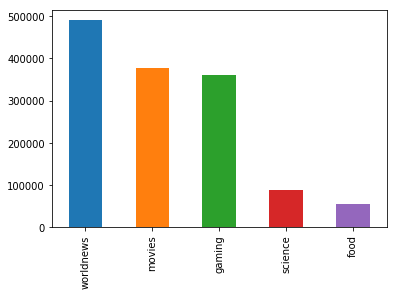

In [74]:
df.subreddit.value_counts().plot(kind='bar')

**Type Conversion** We need to make sure that we are handling categorical variables appropriately. 

In [8]:
df['subreddit'] = df.subreddit.astype('category')
df['subreddit_id'] = df.subreddit_id.astype('category')
df['distinguished'] = df.distinguished.astype('category')
df['link_id'] = df.link_id.astype('category')

**Deleting Features** In exploring the data, we found that some variables are not helpful for us in our efforts to predict reddit scores. Here are variables that we chose to remove, with a quick reason why we chose to do so – 
- `archived` - There are no archived comments in our reduced dataset. 
- `retrieved_on` - Retrieved at least 104 hours after the comment, far long enough for most threads to die. 
- `id` - The variable `name` also uniquely identifies comments, rendering `id` irrelevant. 
- `author_flair_css_class` - Exploration of using this variable & `author_flair_text` proved fruitless.
- `author_flair_text` - Ditto
- `removal_reason` - Only 7 comments were deleted (`removal_reason = legal`). We will treat those comments as outliers that would not help in predicting the scores of new comments. 

In [44]:
# Remove superfluous explanatory variables
df.drop(['archived', 'retrieved_on', 'id',
         'author_flair_css_class', 'author_flair_text',
         'removal_reason'], axis=1, inplace=True)

**Specific Feature Touch-Ups** We need to edit some features to make them more useful to us. 

In [48]:
# Replace 'NaN' with 'user'
df.distinguished.replace(to_replace=np.NaN, value='user', inplace=True)

# Convert created_utc to datetime
df['time'] = pd.to_datetime(df.created_utc, unit='s')

In [49]:
df.columns

Index(['created_utc', 'ups', 'subreddit_id', 'link_id', 'name', 'score_hidden',
       'subreddit', 'gilded', 'downs', 'author', 'score', 'body',
       'distinguished', 'edited', 'controversiality', 'parent_id'],
      dtype='object')

**Size of the Dataset**

In [13]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'0.7322739034038498 GB'

Note that we have narrowed our dataset from `5.13GB` to `0.73GB`. Quite a reduction!

**Additional Variable Creation**

`time_lapse` - An interesting feature for a given observation would be the amount of time since the first comment in a thread. Let's calculate this. 

In [55]:
# Find the time of the first comment in a thread
df_first_comment = df[['link_id', 'time']].groupby(by=['link_id']).min()

# Create a dictionary of {link_id -> timestamp} pairs
df_first_comment_dict = df_first_comment.to_dict('index')

# Funct that takes in {link_id, timestamp} pair & returns the time elapsed since the first comment in that link_id.
def time_lapse(x):
    return df_first_comment_dict[x]['time']

# Add a column of the time_elapsed from the first comment in a link_id
df['time_lapse'] = df.time - df.link_id.apply(time_lapse)

# Convert the type of time_lapse back to seconds
df.time_lapse = df.time_lapse.apply(lambda x: x.total_seconds())

An interesting observation is that there are on average `23.60` comments-per-thread.  

In [60]:
# Total comments / unique threads 
len(df.link_id) / len(df.link_id.unique())

23.598947123827227

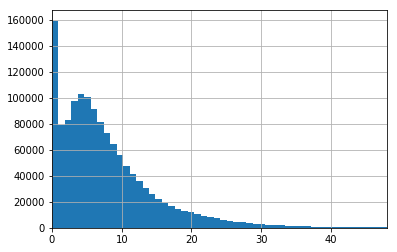

In [23]:
# hours after first comment in thread
(df.time_lapse / (60*60)).hist(bins=800).set_xlim((0, 48));

We see that most comment threads die after 40 hours. Because of this behaviour, we find that the `retrieved_on` feature is rather superfluous, as the all of the data was collected at least 104 hours (calulation below) after the comment was left. Thus, we don't worry that the data collection process diminished the score in any particular way. 

In [57]:
# The number of hours between when the comment was posted & when it was scraped
t = (df.retrieved_on - df.created_utc) / 60 / 60

t.min()

104.2038888888889

In [3]:
def pd_to_dict(df, index='', column=''):
    return pd.Series(df[column].values, index=df[index]).to_dict()

In [25]:
comment_to_parent_dict = pd_to_dict(df[['name', 'parent_id']],
                                    index='name', column='parent_id')

In [26]:
len(comment_to_parent_dict)

1372864

In [27]:
def get_depth(x):
    counter = 0
    temp = x
    while True:
        if temp[:3] == 't3_':
            return counter
        try:
            temp = comment_to_parent_dict[temp]
        except KeyError:
            return np.nan
        counter += 1

In [28]:
df['depth'] = df['name'].apply(get_depth)

In [29]:
df.depth.isna().sum() / float(df.shape[0])

0.01057424479045266

In [30]:
df['linked_sr'] = df.body.apply(lambda x: re.findall(r"/r/([^\s/]+)", x))

In [31]:
df['body'] = df.body.apply(lambda x: re.sub(r"(/r/[^\s/]+)", '', x))

In [32]:
url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

In [33]:
def get_domains(x):
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    urls = re.findall(url_regex, x)
    try:
        domain_names = [urlparse(url).netloc.split('.')[-2] for url in urls]
    except:
        return []
    return domain_names

In [34]:
df['linked_urls'] = df.body.apply(lambda x: get_domains(x))

In [35]:
def remove_urls(x):
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    return re.sub(url_regex, '', x)

In [36]:
df['body'] = df.body.apply(lambda x: remove_urls(x))

In [37]:
df['no_of_linked_sr'] = df['linked_sr'].apply(lambda x: len(x))
df['no_of_linked_urls'] = df['linked_urls'].apply(lambda x: len(x))

In [38]:
all_linked_sr = []
for l in df.linked_sr.values:
    all_linked_sr += l
len(all_linked_sr)

35356

In [39]:
top_sr_links = Counter(all_linked_sr)
top_sr_links.most_common(20)

[('worldnews', 4946),
 ('worldnews)', 2796),
 ('worldnews.', 2489),
 ('help', 2387),
 ('worldnews](http:', 2387),
 ('food),', 1594),
 ('gaming', 1435),
 ('food)', 1283),
 ('movies', 1225),
 ('science', 1044),
 ('movies)', 467),
 ('EverythingScience.', 459),
 ('AutoModerator', 452),
 ('conspiracy', 241),
 ('science.', 206),
 ('movies.', 191),
 ('Movies', 176),
 ('food', 174),
 ('nottheonion', 156),
 ('science)', 136)]

Should not probably use the actual names.

In [40]:
all_linked_urls = []
for l in df.linked_urls.values:
    all_linked_urls += l
len(all_linked_urls)

106993

In [41]:
top_url_links = Counter(all_linked_urls)
top_url_links.most_common(15)

[('reddit', 20232),
 ('youtube', 14216),
 ('wikipedia', 11078),
 ('imgur', 8154),
 ('youtu', 3616),
 ('redditblog', 2393),
 ('imdb', 2132),
 ('co', 1811),
 ('theguardian', 823),
 ('google', 733),
 ('github', 606),
 ('wordpress', 556),
 ('nytimes', 508),
 ('twitter', 432),
 ('amazon', 425)]

In [42]:
allowed_urls = [i[0] for i in top_url_links.most_common(15)]

In [43]:
def remove_urls(x):
    y = []
    for i in x:
        if i in allowed_urls:
            y += [i]
    return y

In [44]:
df['a_linked_urls'] = df['linked_urls'].apply(lambda x: remove_urls(x))

Small i doesn't work for subjectivity

In [45]:
df['subjectivity'] = df['body'].str.count('I ')

In [46]:
df['is_edited'] = df.edited.apply(lambda x: x > 0)

In [47]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'0.9774239446984363 GB'

To check if the comment is quotes another comment.

In [48]:
# if the comment is qouted
df['is_quoted'] = df.body.str.contains('&gt;')

In [49]:
df['no_quoted'] = df.body.str.count('&gt;')

In [50]:
comment_to_score = pd_to_dict(df[['name', 'score']],
                              index='name', column='score')

In [51]:
def get_parent_score(x):
    try:
        return comment_to_score[x]
    except:
        return 0

In [52]:
df['parent_score'] = df.parent_id.apply(lambda x: get_parent_score(x))

In [54]:
comment_to_time = pd_to_dict(df[['name', 'time']],
                              index='name', column='time')

In [70]:
def get_time_since_parent(pi):
    try:
        return comment_to_time[pi]
    except:
        return np.nan

In [75]:
df['time_since_parent'] = df.parent_id.apply(get_time_since_parent)

In [80]:
df.loc[df.time_since_parent.isna(), 'time_since_parent'] = df.time

In [82]:
df.time_since_parent = df.time - df.time_since_parent

In [84]:
df.time_since_parent = df.time_since_parent.apply(lambda x: x.total_seconds())

In [85]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [86]:
analyser = SentimentIntensityAnalyzer()

In [87]:
def get_sentiment(x):
    return analyser.polarity_scores(x)

In [4]:
num_partitions = 100
num_cores = 4

In [5]:
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [90]:
def wrapper_get_sentiment(df):
    df['sentiment'] = df['body'].apply(get_sentiment)
    return df

In [91]:
sentiment = parallelize_dataframe(df['body'].to_frame(), wrapper_get_sentiment)

In [92]:
sentiment.drop(['body'], axis=1, inplace=True)

In [93]:
df['senti_neg'] = sentiment['sentiment'].apply(lambda x: x['neg'])
df['senti_neu'] = sentiment['sentiment'].apply(lambda x: x['neu'])
df['senti_pos'] = sentiment['sentiment'].apply(lambda x: x['pos'])
df['senti_comp'] = sentiment['sentiment'].apply(lambda x: x['compound'])

In [94]:
del sentiment

In [95]:
df.to_pickle('Data/working_sub.pkl')

In [6]:
df = pd.read_pickle('Data/working_sub.pkl')

In [7]:
df.shape

(1372864, 34)

In [7]:
# sub_punct = lambda x: re.sub(r'['+string.punctuation+']+', ' ', x)
# df['body'] = df['body'].apply(sub_punct)

In [8]:
def get_word_count(df):
    df['word_count'] = df['body'].apply(lambda x: len(x.split()))
    return df

In [9]:
word_counts = parallelize_dataframe(df['body'].to_frame(), get_word_count)
df['word_counts'] = word_counts.word_count

In [10]:
del word_counts

In [11]:
import string

In [12]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [13]:
table = str.maketrans({key: ' ' for key in string.digits + string.punctuation + '\t\n\r'})

In [14]:
def load_glove(filename):
    glove = {}
    with open(filename, 'r') as read_file:
        for line in read_file:
            key = line.split(' ')[0]
            vector = np.array(line.split(' ')[1:], dtype=np.float)
            glove[key] = vector

    return glove

In [15]:
def words(text):
    text = text.lower()
    text = text.translate(table).strip()
    terms = text.split(' ')
    terms = [t for t in terms if len(t) > 2]
    terms = [t for t in terms if t not in ENGLISH_STOP_WORDS]

    return terms

In [45]:
def doc2vec(text, gloves):
    count_words = 0
    final_vector = 0
    terms = words(text)

    for t in terms:
        if t in gloves.keys():
            count_words += 1
            final_vector += gloves[t]
    if count_words != 0:
        return final_vector / count_words
    else:
        return None

In [33]:
gloves = load_glove('Data/glove.6B.50d.txt')

In [34]:
def wrapper_get_centroid(df):
    df['doc2vec'] = df['body'].apply(lambda x: doc2vec(x, gloves))
    return df

In [35]:
doc2vec = parallelize_dataframe(df['body'].to_frame(), wrapper_get_centroid)

In [36]:
doc2vec = doc2vec.doc2vec.values

In [37]:
df['doc2vec'] = doc2vec

In [ ]:
del gloves

In [23]:
del doc2vec

In [38]:
comment_to_body = pd_to_dict(df[['name', 'body']],
                                index='name', column='body')
comment_to_parent = pd_to_dict(df[['name', 'parent_id']],
                                index='name', column='parent_id')

In [46]:
def get_cosine_angle(cmnt_id):
    child = comment_to_body[cmnt_id]
    try:
        parent = comment_to_body[comment_to_parent[cmnt_id]]
    except KeyError:
        return None
    child = doc2vec(child, gloves)
    parent = doc2vec(parent, gloves)
    if child is None:
        return None
    if parent is None:
        return None
    return child.dot(parent)

In [47]:
df.name.values[-10:]

array(['t1_crrbdt2', 't1_crrbdtt', 't1_crrbdvn', 't1_crrbdxj',
       't1_crrbdxr', 't1_crrbebf', 't1_crrbecs', 't1_crrbedn',
       't1_crrbefm', 't1_crrbeft'], dtype=object)

In [48]:
get_cosine_angle('t1_crrbdvn')

6.900523655555543

In [49]:
def wrapper_get_cosine(df):
    df['cosine_angle'] = df['name'].apply(get_cosine_angle)
    return df

In [50]:
cosine_angle = parallelize_dataframe(df['name'].to_frame(), wrapper_get_cosine)

In [51]:
df['cos_angle'] = cosine_angle.cosine_angle

In [52]:
import gc
gc.collect()

1167

In [28]:
# df.to_pickle('Data/working_sub_glove.pkl')

In [53]:
df.word_counts.quantile(0.99)

215.0

In [54]:
# remove comments that have  more than 500 words (outliers)
df = df[df['word_counts'] < 250]

In [55]:
df = df[~df.depth.isna()]

In [56]:
df.drop(['score_hidden'], axis=1, inplace=True)

In [57]:
df = df[df.body != '[deleted]']
df = df[df.body != '[removed]']
df = df[df.body != '']

In [59]:
df = df[~df.doc2vec.isna()]

In [63]:
df = df[~df.cos_angle.isna()]

In [64]:
df.shape

(831960, 36)

In [66]:
df.columns

Index(['created_utc', 'ups', 'subreddit_id', 'link_id', 'name', 'subreddit',
       'gilded', 'downs', 'author', 'score', 'body', 'distinguished', 'edited',
       'controversiality', 'parent_id', 'time', 'time_lapse', 'depth',
       'linked_sr', 'linked_urls', 'no_of_linked_sr', 'no_of_linked_urls',
       'a_linked_urls', 'subjectivity', 'is_edited', 'is_quoted', 'no_quoted',
       'parent_score', 'time_since_parent', 'senti_neg', 'senti_neu',
       'senti_pos', 'senti_comp', 'word_counts', 'doc2vec', 'cos_angle'],
      dtype='object')

In [67]:
df.drop(['doc2vec'], inplace=True, axis=1)

In [69]:
df.to_pickle('Data/temp.pkl')

In [6]:
df = pd.read_pickle('Data/temp.pkl')

In [68]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'0.6573981436695813 GB'

In [33]:
doc2vec = np.vstack([i for i in df.doc2vec.values])

In [49]:
np.save('Data/doc2vec.npy', doc2vec)

In [34]:
df.drop(['doc2vec'], inplace=True, axis=1)

In [7]:
df.columns

Index(['created_utc', 'ups', 'subreddit_id', 'link_id', 'name', 'subreddit',
       'gilded', 'downs', 'author', 'score', 'body', 'distinguished', 'edited',
       'controversiality', 'parent_id', 'time', 'time_lapse', 'depth',
       'linked_sr', 'linked_urls', 'no_of_linked_sr', 'no_of_linked_urls',
       'a_linked_urls', 'subjectivity', 'is_edited', 'is_quoted', 'no_quoted',
       'parent_score', 'time_since_parent', 'senti_neg', 'senti_neu',
       'senti_pos', 'senti_comp', 'word_counts', 'cos_angle'],
      dtype='object')

In [40]:
df.is_quoted.value_counts()

False    1132111
True       51724
Name: is_quoted, dtype: int64

In [51]:
df.to_pickle('Data/working_sub_d2v.pkl')

In [5]:
df = pd.read_pickle('Data/working_sub_d2v.pkl')
doc2vec = np.load('Data/doc2vec.npy')

In [65]:
vectorizer = TfidfVectorizer(min_df=30)
#X_tfidf = vectorizer.fit_transform(df['body'])

In [8]:
numeric_cols = ['gilded', 'controversiality', 'time_lapse', 'depth', 'no_of_linked_sr',
                'no_of_linked_urls', 'subjectivity', 'no_quoted', 'parent_score',
                'senti_neg', 'senti_neu', 'senti_pos', 'senti_comp', 'word_counts',
                'time_since_parent', 'cos_angle']

In [9]:
from scipy.sparse import hstack

In [10]:
lb = LabelBinarizer()
mlb = MultiLabelBinarizer()

y = df.score.values
x = np.hstack((lb.fit_transform(df.subreddit),
               lb.fit_transform(df.distinguished),
               lb.fit_transform(df.is_edited),
               lb.fit_transform(df.is_quoted),
               mlb.fit_transform(df.a_linked_urls),
               df.loc[:, numeric_cols].values))
               #, doc2vec))

In [12]:
del df, doc2vec

In [13]:
np.random.seed(42)

In [14]:
x.shape

(831960, 41)

In [15]:
y.shape

(831960,)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=42)

Things to try:
1. Take cosine between the word to vec for past 2 comments
2. Remove the first comment
3. Try gradient boosting
4. Try getting 

In [17]:
from sklearn.ensemble import RandomForestRegressor

In [29]:
from sklearn.ensemble import GradientBoostingRegressor

In [34]:
m = GradientBoostingRegressor(n_estimators=100, min_samples_leaf=10)
m.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [35]:
y_predicted = m.predict(X_test)
r2 = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
print(f"R-Sq: {r2:.4}")
print(f"RMSE: {np.sqrt(mse)}")

R-Sq: 0.2752
RMSE: 44.0727290134829


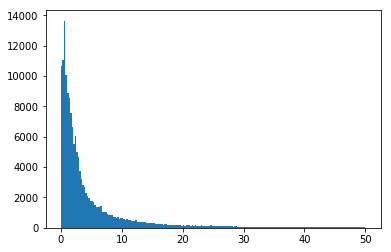

In [36]:
plt.hist(abs(y_test - y_predicted), bins=200, range=[0, 50]);

-------------

In [18]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=10)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [19]:
y_predicted = m.predict(X_test)
r2 = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
print(f"R-Sq: {r2:.4}")
print(f"RMSE: {np.sqrt(mse)}")

R-Sq: 0.2748
RMSE: 44.08580527082157


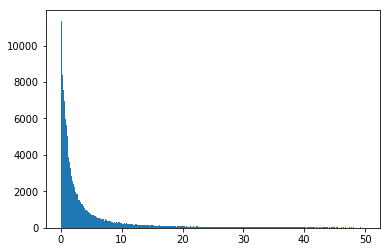

In [28]:
plt.hist(abs(y_test - y_predicted), bins=400, range=[0, 50]);

With raw child 50d glove - with just 10 estimaters

In [47]:
y_predicted = m.predict(X_test)
r2 = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
print(f"R-Sq: {r2:.4}")
print(f"RMSE: {np.sqrt(mse)}")

R-Sq: 0.1107
RMSE: 64.75655527375679


Result with just sentiment and parent score RandomForest 50 estimaters

In [121]:
y_predicted = m.predict(X_test)
r2 = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
print(f"R-Sq: {r2:.4}")
print(f"RMSE: {np.sqrt(mse)}")

R-Sq: 0.1425
RMSE: 60.66416993315583


In [20]:
m = LinearRegression()
m.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [21]:
y_predicted = m.predict(X_test)
r2 = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
print(f"R-Sq: {r2:.4}")
print(f"RMSE: {np.sqrt(mse)}")

R-Sq: 0.07293
RMSE: 66.1184751479385


In [ ]:
import pickle

In [ ]:
from joblib import dump, load

In [ ]:
dump(m, 'RF.joblib')